In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

## 合并数据集
pandas对象中的数据可以通过一些内置的方式进行合并：
* pandas.merge可根据一个或多个键将不同DataFrame的行连接起来。
* pandas.concat可以沿着一条轴将多个对象堆叠到一起。
* 实例方法combine_first可以将重复数据编接在一起，用一个对象中的值填充另一个对象中的缺失值。

## 数据库风格的DataFrame合并

In [2]:
df1 = DataFrame({'key': ['b', 'b', 'a', 'c', 'a', 'a', 'b'],
                 'data1': range(7)})

In [3]:
df2 = DataFrame({'key': ['a', 'b', 'd'],
                'data2': range(3)})

In [4]:
df1

,data1,key
0,0,b
1,1,b
2,2,a
3,3,c
4,4,a
5,5,a
6,6,b


In [5]:
df2

,data2,key
0,0,a
1,1,b
2,2,d


这是一种多对一的合并。df1中的数据有多个被标记为a和b的行，而df2中的key列的每个值则仅对应一行。对这些对象调用merge即可得到：

In [6]:
pd.merge(df1, df2)

,data1,key,data2
0,0,b,1
1,1,b,1
2,6,b,1
3,2,a,0
4,4,a,0
5,5,a,0


注意，并没有指明要用哪个列进行连接，如果没有指定，merge就会将重叠列的列名当作键。不过做好显式指定一下：

In [7]:
pd.merge(df1, df2, on='key')

,data1,key,data2
0,0,b,1
1,1,b,1
2,6,b,1
3,2,a,0
4,4,a,0
5,5,a,0


如果两个对象的列名不同，也可以分别进行指定：

In [8]:
df3 = DataFrame({'lkey': ['b', 'b', 'a', 'c', 'a', 'a', 'b'],
                'data1': range(7)}) 

In [9]:
df4 = DataFrame({'rkey': ['a', 'b', 'd'],
                 'data2': range(3)})

In [10]:
pd.merge(df3, df4, left_on='lkey', right_on='rkey')

,data1,lkey,data2,rkey
0,0,b,1,b
1,1,b,1,b
2,6,b,1,b
3,2,a,0,a
4,4,a,0,a
5,5,a,0,a


默认情况下，merge做的是“inner”连接，结果中的键是交集，其他方式还有“left”、“right”以及“outer”。外连接求取的是键的并集，组合了左连接和右连接的效果：

In [11]:
pd.merge(df1, df2, how='outer')

,data1,key,data2
0,0.0,b,1.0
1,1.0,b,1.0
2,6.0,b,1.0
3,2.0,a,0.0
4,4.0,a,0.0
5,5.0,a,0.0
6,3.0,c,NaN
7,NaN,d,2.0


多对多的合并操作非常简单，无需额外的工作。如下所示：

In [12]:
df1 = DataFrame({'key':['b', 'b', 'a', 'c', 'a', 'b'],
                 'data1': range(6)})

In [13]:
df2 = DataFrame({'key': ['a', 'b', 'a', 'b', 'd'],
                 'data2': range(5)})

In [14]:
df1

,data1,key
0,0,b
1,1,b
2,2,a
3,3,c
4,4,a
5,5,b


In [15]:
df2

,data2,key
0,0,a
1,1,b
2,2,a
3,3,b
4,4,d


多对多连接产生的是行的笛卡尔积。由左边的DataFrame有3个“b”行，右边的有2个，所以最终结果中就有6个“b”行。连接方式只影响出现在结果中的键：

In [16]:
pd.merge(df1, df2, how='inner')

,data1,key,data2
0,0,b,1
1,0,b,3
2,1,b,1
3,1,b,3
4,5,b,1
5,5,b,3
6,2,a,0
7,2,a,2
8,4,a,0
9,4,a,2


要根据多个键进行合并，传入一个由列名组成的列表即可：

In [17]:
left = DataFrame({'key1': ['foo', 'foo', 'bar'],
                  'key2': ['one', 'two', 'one'],
                  'lval': [1, 2, 3]})

In [18]:
right = DataFrame({'key1': ['foo', 'foo', 'bar', 'bar'],
                   'key2': ['one', 'one', 'one', 'two'],
                   'rval': [4, 5, 6, 7]})

In [19]:
pd.merge(left, right, on=['key1', 'key2'], how='outer')

,key1,key2,lval,rval
0,foo,one,1.0,4.0
1,foo,one,1.0,5.0
2,foo,two,2.0,NaN
3,bar,one,3.0,6.0
4,bar,two,NaN,7.0


In [20]:
pd.merge(left, right, on='key1')

,key1,key2_x,lval,key2_y,rval
0,foo,one,1,one,4
1,foo,one,1,one,5
2,foo,two,2,one,4
3,foo,two,2,one,5
4,bar,one,3,one,6
5,bar,one,3,two,7


In [21]:
pd.merge(left, right, on='key1', suffixes=('_left', '_right'))

,key1,key2_left,lval,key2_right,rval
0,foo,one,1,one,4
1,foo,one,1,one,5
2,foo,two,2,one,4
3,foo,two,2,one,5
4,bar,one,3,one,6
5,bar,one,3,two,7


## 索引上的合并
有时候DataFrame中的连接键位于其索引中。在这种情况下，你可以传入left_index=True或right_index=True（或两个都传）以说明索引应该被用作连接键：

In [22]:
left1 = DataFrame({'key': ['a', 'b', 'a', 'a', 'b', 'c'],
                   'value': range(6)})

In [23]:
right1 = DataFrame({'group_val': [3.5, 7]}, index=['a', 'b'])

In [24]:
left1

,key,value
0,a,0
1,b,1
2,a,2
3,a,3
4,b,4
5,c,5


In [25]:
right1

,group_val
a,3.5
b,7.0


In [26]:
pd.merge(left1, right1, left_on='key', right_index=True)

,key,value,group_val
0,a,0,3.5
2,a,2,3.5
3,a,3,3.5
1,b,1,7.0
4,b,4,7.0


由于默认的merge方法是求取连接键的交集，因此可通过外连接的方式得到它们的并集：

In [27]:
pd.merge(left1, right1, left_on='key', right_index=True, how='outer')

,key,value,group_val
0,a,0,3.5
2,a,2,3.5
3,a,3,3.5
1,b,1,7.0
4,b,4,7.0
5,c,5,NaN


对于层次化索引的数据，事情就有点复杂了：

In [28]:
lefth = DataFrame({'key1': ['Ohio', 'Ohio', 'Ohio', 'Nevada', 'Nevada'],
                  'key2': [2000, 2001, 2002, 2001, 2002],
                  'data': np.arange(5.)})

In [29]:
righth = DataFrame(np.arange(12).reshape((6, 2)),
                  index=[['Nevada', 'Nevada', 'Ohio', 'Ohio', 'Ohio', 'Ohio'],
                         [2001, 2000, 2000, 2000, 2001, 2002]],
                  columns=['event1', 'event2'])

In [30]:
lefth

,data,key1,key2
0,0.0,Ohio,2000
1,1.0,Ohio,2001
2,2.0,Ohio,2002
3,3.0,Nevada,2001
4,4.0,Nevada,2002


In [31]:
righth

event1  event2
Nevada 2001       0       1
       2000       2       3
Ohio   2000       4       5
       2000       6       7
       2001       8       9
       2002      10      11

这种情况下，必须以列表的形式指明用作合并键的多个列（注意对重复索引值的处理）:

In [32]:
pd.merge(lefth, righth, left_on=['key1', 'key2'], right_index=True)

,data,key1,key2,event1,event2
0,0.0,Ohio,2000,4,5
0,0.0,Ohio,2000,6,7
1,1.0,Ohio,2001,8,9
2,2.0,Ohio,2002,10,11
3,3.0,Nevada,2001,0,1


In [33]:
pd.merge(lefth, righth, left_on=['key1', 'key2'], right_index=True, how='outer')

,data,key1,key2,event1,event2
0,0.0,Ohio,2000,4.0,5.0
0,0.0,Ohio,2000,6.0,7.0
1,1.0,Ohio,2001,8.0,9.0
2,2.0,Ohio,2002,10.0,11.0
3,3.0,Nevada,2001,0.0,1.0
4,4.0,Nevada,2002,NaN,NaN
4,NaN,Nevada,2000,2.0,3.0


同时使用合并双方的索引也没问题：

In [34]:
left2 = DataFrame([[1., 2.], [3., 4.], [5., 6.]],
                  index=['a', 'c', 'e'],
                  columns=['Ohio', 'Nevada'])

In [35]:
right2 = DataFrame([[7., 8.], [9., 10.], [11., 12.], [13, 14]],
                   index=['b', 'c', 'd', 'e'],
                   columns=['Missouri', 'Alabama'])

In [36]:
left2

,Ohio,Nevada
a,1.0,2.0
c,3.0,4.0
e,5.0,6.0


In [37]:
right2

,Missouri,Alabama
b,7.0,8.0
c,9.0,10.0
d,11.0,12.0
e,13.0,14.0


In [38]:
pd.merge(left2, right2, how='outer', left_index=True, right_index=True)

,Ohio,Nevada,Missouri,Alabama
a,1.0,2.0,NaN,NaN
b,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0
d,NaN,NaN,11.0,12.0
e,5.0,6.0,13.0,14.0


DataFrame还有一个join实例方法，它能更为方便地实现索引合并。它还可以用于合并多个带有相同或相似索引的DataFrame对象，而不管他们之间有没有重叠的列。

In [39]:
left2.join(right2, how='outer')

,Ohio,Nevada,Missouri,Alabama
a,1.0,2.0,NaN,NaN
b,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0
d,NaN,NaN,11.0,12.0
e,5.0,6.0,13.0,14.0


In [40]:
left1.join(right1, on='key')

,key,value,group_val
0,a,0,3.5
1,b,1,7.0
2,a,2,3.5
3,a,3,3.5
4,b,4,7.0
5,c,5,NaN


对于简单的索引合并，还可以向join传入一组DataFrame：

In [41]:
another = DataFrame([[7, 8], [9, 10], [11, 12], [16, 17]],
                    index=['a', 'c', 'e', 'f'],
                    columns=['New York', 'Oregon'])

In [42]:
left2.join([right2, another])

,Ohio,Nevada,Missouri,Alabama,New York,Oregon
a,1.0,2.0,NaN,NaN,7,8
c,3.0,4.0,9.0,10.0,9,10
e,5.0,6.0,13.0,14.0,11,12


In [43]:
left2.join([right2, another], how='outer')

,Ohio,Nevada,Missouri,Alabama,New York,Oregon
a,1.0,2.0,NaN,NaN,7.0,8.0
b,NaN,NaN,7.0,8.0,NaN,NaN
c,3.0,4.0,9.0,10.0,9.0,10.0
d,NaN,NaN,11.0,12.0,NaN,NaN
e,5.0,6.0,13.0,14.0,11.0,12.0
f,NaN,NaN,NaN,NaN,16.0,17.0


## 轴向连接
另一种数据合并运算也被称作连接（concatenation）、绑定（binding）或堆叠（stacking）。NumPy有一个用于合并原始NumPy数组的concatenation函数：

In [44]:
arr = np.arange(12).reshape((3, 4))

In [45]:
arr

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [46]:
np.concatenate([arr, arr], axis=1)

array([[ 0,  1,  2,  3,  0,  1,  2,  3],
       [ 4,  5,  6,  7,  4,  5,  6,  7],
       [ 8,  9, 10, 11,  8,  9, 10, 11]])

假设有三个没有重叠索引的Series：

In [47]:
s1 = Series([0, 1], index=['a', 'b'])

In [48]:
s2 = Series([2, 3, 4], index=['c', 'd', 'e'])

In [49]:
s3 = Series([5, 6], index=['f', 'g'])

对这些对象调用concat可以将值和索引粘合在一起：

In [50]:
pd.concat([s1, s2, s3])

a    0
b    1
c    2
d    3
e    4
f    5
g    6
dtype: int64

默认情况下，concat是在axis=0上工作的，最终产生一个新的Series。  
如果传入axis=1，则结果就会变成一个DataFrame（axis=1是列）：

In [51]:
pd.concat([s1, s2, s3], axis=1)

,0,1,2
a,0.0,NaN,NaN
b,1.0,NaN,NaN
c,NaN,2.0,NaN
d,NaN,3.0,NaN
e,NaN,4.0,NaN
f,NaN,NaN,5.0
g,NaN,NaN,6.0


这种情况下，另外一条轴没有重叠，从索引的有序并集（外连接）上就能看出来。传入join='innner'即可得到它们的交集：

In [52]:
s4 = pd.concat([s1 * 5, s3])

In [53]:
pd.concat([s1, s4], axis=1)

,0,1
a,0.0,0
b,1.0,5
f,NaN,5
g,NaN,6


In [54]:
pd.concat([s1, s4], axis=1, join='inner')

,0,1
a,0,0
b,1,5


可以通过join_axes指定要在其他轴上使用的索引：

In [55]:
pd.concat([s1, s4], axis=1, join_axes=[['a', 'c', 'b', 'e']])

,0,1
a,0.0,0.0
c,NaN,NaN
b,1.0,5.0
e,NaN,NaN


不过有个问题，参与连接的片段在结果中区分不开。假设想要在连接轴上创建一个层次化索引，使用keys参数即可达到这个目的：

In [56]:
result = pd.concat([s1, s1, s3], keys=['ones', 'two', 'three'])

In [57]:
result

ones   a    0
       b    1
two    a    0
       b    1
three  f    5
       g    6
dtype: int64

In [58]:
result.unstack()

,a,b,f,g
ones,0.0,1.0,NaN,NaN
two,0.0,1.0,NaN,NaN
three,NaN,NaN,5.0,6.0


如果沿着axis=1对Series进行合并，则keys就会成为DataFrame的列头：

In [59]:
pd.concat([s1, s2, s3], axis=1, keys=['one', 'two', 'three'])

,one,two,three
a,0.0,NaN,NaN
b,1.0,NaN,NaN
c,NaN,2.0,NaN
d,NaN,3.0,NaN
e,NaN,4.0,NaN
f,NaN,NaN,5.0
g,NaN,NaN,6.0


同样的逻辑对DataFrame对象也是一样：

In [60]:
df1 = DataFrame(np.arange(6).reshape(3, 2),
                index=['a', 'b', 'c'],
                columns=['one', 'two'])

In [61]:
df2 = DataFrame(5 + np.arange(4).reshape(2, 2),
                index=['a', 'c'],
                columns=['three', 'four'])

In [62]:
pd.concat([df1, df2], axis=1, keys=['level1', 'level2'])

level1     level2     
     one two  three four
a      0   1    5.0  6.0
b      2   3    NaN  NaN
c      4   5    7.0  8.0

如果传入的不是列表而是一个字典，则字典的键就会被当做keys选项的值：

In [63]:
pd.concat({'level1': df1, 'level2': df2}, axis=1)

level1     level2     
     one two  three four
a      0   1    5.0  6.0
b      2   3    NaN  NaN
c      4   5    7.0  8.0

此外还有两个用于管理层次化索引创建方式的参数：

In [64]:
pd.concat([df1, df2], axis=1, keys=['level1', 'level2'],
          names=['upper', 'lower'])

upper level1     level2     
lower    one two  three four
a          0   1    5.0  6.0
b          2   3    NaN  NaN
c          4   5    7.0  8.0

最后一个需要考虑的问题是，跟当前分析工作无关的DataFrame行索引：

In [65]:
df1 = DataFrame(np.random.randn(3, 4), columns=['a', 'b', 'c', 'd'])

In [66]:
df2 = DataFrame(np.random.randn(2, 3), columns=['b', 'd', 'a'])

In [67]:
df1

,a,b,c,d
0,-0.603980,-0.701476,0.214135,1.309160
1,0.113245,-0.669716,-0.857861,0.741927
2,0.280600,-1.626387,0.224737,-0.309123


In [68]:
df2

,b,d,a
0,-2.904645,0.539683,1.181957
1,-1.009348,0.805176,-0.760169


In [69]:
pd.concat([df1, df2], ignore_index=True)

,a,b,c,d
0,-0.603980,-0.701476,0.214135,1.309160
1,0.113245,-0.669716,-0.857861,0.741927
2,0.280600,-1.626387,0.224737,-0.309123
3,1.181957,-2.904645,NaN,0.539683
4,-0.760169,-1.009348,NaN,0.805176


## 合并重叠数据
还有一种数据组合问题不能用简单的合并（merge）或连接（concatenation）运算来处理。  
比如说你可能有索引全部或部分重叠的两个数据集。

In [70]:
a = Series([np.nan, 2.5, np.nan, 3.5, 4.5, np.nan],
           index=['f', 'e', 'd', 'c', 'b', 'a'])

In [71]:
b = Series(np.arange(len(a), dtype=np.float64),
            index=['f', 'e', 'd', 'c', 'b', 'a'])

In [72]:
b[-1] = np.nan

In [73]:
a

f    NaN
e    2.5
d    NaN
c    3.5
b    4.5
a    NaN
dtype: float64

In [74]:
b

f    0.0
e    1.0
d    2.0
c    3.0
b    4.0
a    NaN
dtype: float64

In [75]:
np.where(pd.isnull(a), b, a)

array([0. , 2.5, 2. , 3.5, 4.5, nan])

Series有一个combine_first方法：

In [76]:
b[:-2].combine_first(a[2:])

a    NaN
b    4.5
c    3.0
d    2.0
e    1.0
f    0.0
dtype: float64

In [77]:
df1 = DataFrame({'a': [1, np.nan, 5, np.nan],
                 'b': [np.nan, 2, np.nan, 6],
                 'c': range(2, 18, 4)})

In [78]:
df2 = DataFrame({'a': [5, 4, np.nan, 3, 7],
                 'b': [np.nan, 3, 4, 6, 8]})

In [79]:
df1.combine_first(df2)

,a,b,c
0,1.0,NaN,2.0
1,4.0,2.0,6.0
2,5.0,4.0,10.0
3,3.0,6.0,14.0
4,7.0,8.0,NaN


## 重塑和轴向旋转
有许多用于重新排列表格型数据的基础运算。这些函数也称作重塑（reshape）或轴向旋转（pivot）运算。

## 重塑层次化索引
* stack：将数据的列“旋转”为行。
* unstack：将数据的行“旋转”为列。

In [80]:
data = DataFrame(np.arange(6).reshape((2, 3)),
                 index=pd.Index(['Ohio', 'Colorado'], name='state'),
                 columns=pd.Index(['one', 'two', 'three'], name='number'))

In [81]:
data

number,one,two,three
state,,,
Ohio,0,1,2
Colorado,3,4,5


In [82]:
result = data.stack()

In [83]:
result

state     number
Ohio      one       0
          two       1
          three     2
Colorado  one       3
          two       4
          three     5
dtype: int32

In [84]:
result.unstack() # 默认最内层

number,one,two,three
state,,,
Ohio,0,1,2
Colorado,3,4,5


In [85]:
result.unstack(0)

state,Ohio,Colorado
number,,
one,0,3
two,1,4
three,2,5


In [86]:
result.unstack('state')

state,Ohio,Colorado
number,,
one,0,3
two,1,4
three,2,5


如果不是所有的级别值都能在各分组中找到的话，则unstack操作可能会引入缺失数据：

In [87]:
s1 = Series([0, 1, 2, 3], index=['a', 'b', 'c', 'd'])

In [88]:
s2 = Series([4, 5, 6], index=['c', 'd', 'e'])

In [89]:
data2 = pd.concat([s1, s2], keys=['one', 'two'])

In [90]:
data2

one  a    0
     b    1
     c    2
     d    3
two  c    4
     d    5
     e    6
dtype: int64

In [91]:
data2.unstack()

,a,b,c,d,e
one,0.0,1.0,2.0,3.0,NaN
two,NaN,NaN,4.0,5.0,6.0


stack默认会滤除缺失数据，因此该运算是可逆的：

In [92]:
data2.unstack().stack()

one  a    0.0
     b    1.0
     c    2.0
     d    3.0
two  c    4.0
     d    5.0
     e    6.0
dtype: float64

In [93]:
data2.unstack().stack(dropna=False)

one  a    0.0
     b    1.0
     c    2.0
     d    3.0
     e    NaN
two  a    NaN
     b    NaN
     c    4.0
     d    5.0
     e    6.0
dtype: float64

## 将“长格式”旋转为“宽格式”
时间序列数据通常是以所谓的“长格式”（long）或“堆叠格式”（stacked）存储在数据库和csv中的：

## 移除重复数据

In [94]:
data = DataFrame({'k1': ['one'] * 3 + ['two'] * 4,
                  'k2': [1, 1, 2, 3, 3, 4, 4]})

In [95]:
data

,k1,k2
0,one,1
1,one,1
2,one,2
3,two,3
4,two,3
5,two,4
6,two,4


DataFrame的duplicated方法返回一个布尔型Series，表示各行是否是重复行：

In [96]:
data.duplicated()

0    False
1     True
2    False
3    False
4     True
5    False
6     True
dtype: bool

还有一个与此相关的drop_duplicates方法，它用于返回一个移除了重复行的DataFrame：

In [97]:
data.drop_duplicates()

,k1,k2
0,one,1
2,one,2
3,two,3
5,two,4


这两个方法默认会判断全部列，也可以指定部分列进行重复项判断。  
假设还有一列值，且只希望根据k1列过滤重复项：

In [98]:
data['v1'] = range(7)

In [99]:
data.drop_duplicates(['k1'])

,k1,k2,v1
0,one,1,0
3,two,3,3


duplicated和drop_duplicates默认保留的是第一个出现的值组合，传入keep='last'则保留最后一个：

In [100]:
data.drop_duplicates(['k1', 'k2'], keep='last')

,k1,k2,v1
1,one,1,1
2,one,2,2
4,two,3,4
6,two,4,6


## 利用函数或映射进行数据转换

In [101]:
data = DataFrame({'food': ['bacon', 'pulled pork', 'bacon', 'Pastrami',
                           'corned beef', 'Bacon', 'pastrami', 'honey ham',
                           'nova lox'],
                  'ounces': [4, 3, 12, 6, 7.5, 8, 3, 5, 6]})

In [102]:
data

,food,ounces
0,bacon,4.0
1,pulled pork,3.0
2,bacon,12.0
3,Pastrami,6.0
4,corned beef,7.5
5,Bacon,8.0
6,pastrami,3.0
7,honey ham,5.0
8,nova lox,6.0


假设你想要添加一列表示肉类食物来源的动物类型。我们先编写一个肉类到动物的映射：

In [103]:
meat_to_animal = {
    'bacon': 'pig',
    'pulled pork': 'pig',
    'pastrami': 'cow',
    'corned beef': 'cow',
    'honey ham': 'pig',
    'nova lox': 'salmon'
}

Series的map方法可以接受一个函数或含有映射关系的字典型对象，但是这里有个小问题，即有些肉类的首写字母大写了，而另一些则没有，因此，我们还需要将各个值转换为小写：

In [104]:
data['animal'] = data['food'].map(str.lower).map(meat_to_animal)

In [105]:
data

,food,ounces,animal
0,bacon,4.0,pig
1,pulled pork,3.0,pig
2,bacon,12.0,pig
3,Pastrami,6.0,cow
4,corned beef,7.5,cow
5,Bacon,8.0,pig
6,pastrami,3.0,cow
7,honey ham,5.0,pig
8,nova lox,6.0,salmon


我们也可以传入一个能够完成全部这些工作的函数：

In [106]:
data['food'].map(lambda x: meat_to_animal[x.lower()])

0       pig
1       pig
2       pig
3       cow
4       cow
5       pig
6       cow
7       pig
8    salmon
Name: food, dtype: object

## 替换值

In [107]:
data = Series([1, -999, 2, -999, -1000, 3])

In [108]:
data

0       1
1    -999
2       2
3    -999
4   -1000
5       3
dtype: int64

In [109]:
data.replace(-999, np.nan)

0       1.0
1       NaN
2       2.0
3       NaN
4   -1000.0
5       3.0
dtype: float64

In [110]:
data.replace([-999, -1000], np.nan)

0    1.0
1    NaN
2    2.0
3    NaN
4    NaN
5    3.0
dtype: float64

如果希望对不同的值进行不同的替换，则传入一个由替换关系组成的列表即可：

In [111]:
data.replace([-999, -1000], [np.nan, 0])

0    1.0
1    NaN
2    2.0
3    NaN
4    0.0
5    3.0
dtype: float64

传入的参数也可以是字典：

In [112]:
data.replace({-999: np.nan, -1000: 0})

0    1.0
1    NaN
2    2.0
3    NaN
4    0.0
5    3.0
dtype: float64

## 重命名轴索引

In [113]:
data = DataFrame(np.arange(12).reshape((3, 4)),
                 index=['Ohio', 'Colorado', 'New York'],
                 columns=['one', 'two', 'three', 'four'])

跟Series一样，轴标签也有一个map方法：

In [114]:
data.index.map(str.upper)

Index(['OHIO', 'COLORADO', 'NEW YORK'], dtype='object')

可以将其赋值给index，这样就可以对DataFrame进行就地修改：

In [115]:
data.index = data.index.map(str.upper)

In [116]:
data

,one,two,three,four
OHIO,0,1,2,3
COLORADO,4,5,6,7
NEW YORK,8,9,10,11


如果想要创建数据集的转换版（而不是修改原始数据），比较使用的方法是rename：

In [117]:
data.rename(index=str.title, columns=str.upper) # title首字母大写，其余小写

,ONE,TWO,THREE,FOUR
Ohio,0,1,2,3
Colorado,4,5,6,7
New York,8,9,10,11


rename可以结合字典型对象实现对部分轴标签的更新：

In [118]:
data.rename(index={'OHIO': 'INDIANA'},
            columns={'three': 'peekaboo'})

,one,two,peekaboo,four
INDIANA,0,1,2,3
COLORADO,4,5,6,7
NEW YORK,8,9,10,11


如果希望就地修改某个数据集，传入inplace=True即可：

In [119]:
# 总是返回DataFrame的引用
_ = data.rename(index={'OHIO': 'INDIANA'}, inplace=True)

In [120]:
data

,one,two,three,four
INDIANA,0,1,2,3
COLORADO,4,5,6,7
NEW YORK,8,9,10,11


## 离散化和面元划分
为了便于分析，连续数据常常被离散化或拆分为“面元”（bin）。  
假设有一组人员数据，而你希望将它们划分为不同的年龄组：

In [121]:
ages = [20, 22, 25, 27, 21, 23, 37, 31, 61, 45, 41, 32]

接下来将这些数据划分为“18到25”， “26到35”，“35到60”以及“60以上”几个面元。使用pandas的cut函数：

In [122]:
bins = [18, 25, 35, 60, 100]

In [123]:
cats = pd.cut(ages, bins)

In [124]:
cats

[(18, 25], (18, 25], (18, 25], (25, 35], (18, 25], ..., (25, 35], (60, 100], (35, 60], (35, 60], (25, 35]]
Length: 12
Categories (4, interval[int64]): [(18, 25] < (25, 35] < (35, 60] < (60, 100]]

In [125]:
cats.labels

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'labels' is deprecated. Use 'codes' instead
  """Entry point for launching an IPython kernel.


array([0, 0, 0, 1, 0, 0, 2, 1, 3, 2, 2, 1], dtype=int8)

In [126]:
cats.codes

array([0, 0, 0, 1, 0, 0, 2, 1, 3, 2, 2, 1], dtype=int8)

In [127]:
cats.categories

IntervalIndex([(18, 25], (25, 35], (35, 60], (60, 100]]
              closed='right',
              dtype='interval[int64]')

In [128]:
pd.value_counts(cats)

(18, 25]     5
(35, 60]     3
(25, 35]     3
(60, 100]    1
dtype: int64

跟“区间”的数学符号一样，圆括号表示开端，而方括号则表示闭端（包括）。  
哪边是闭端可以通过right=False进行修改：

In [129]:
pd.cut(ages, [18, 26, 36, 61, 100], right=False)

[[18, 26), [18, 26), [18, 26), [26, 36), [18, 26), ..., [26, 36), [61, 100), [36, 61), [36, 61), [26, 36)]
Length: 12
Categories (4, interval[int64]): [[18, 26) < [26, 36) < [36, 61) < [61, 100)]

你也可以设置自己的吗面元名称，将labels选项设置为一个列表或数组即可：

In [130]:
group_names = ['Youth', 'YoungAdult', 'MiddleAged', 'Senior']

In [131]:
pd.cut(ages, bins, labels=group_names)

[Youth, Youth, Youth, YoungAdult, Youth, ..., YoungAdult, Senior, MiddleAged, MiddleAged, YoungAdult]
Length: 12
Categories (4, object): [Youth < YoungAdult < MiddleAged < Senior]

如果向cut传入的是面元的数量而不是确切的面元边界，则它会根据数据的最小值和最大值计算等长面元：

In [132]:
data = np.random.rand(20)

In [133]:
pd.cut(data, 4, precision=2)

[(0.24, 0.49], (0.73, 0.97], (0.49, 0.73], (0.49, 0.73], (0.49, 0.73], ..., (0.49, 0.73], (0.24, 0.49], (0.24, 0.49], (0.73, 0.97], (0.00075, 0.24]]
Length: 20
Categories (4, interval[float64]): [(0.00075, 0.24] < (0.24, 0.49] < (0.49, 0.73] < (0.73, 0.97]]

qcut是一个非常类似与cut的函数，它可以根据样本分位数对数据进行面元划分。根据数据的分布情况，cut可能无法使各个面元中含有相同数量的数据点，而qcut由于使用的是样本分位数，因此可以得到大小基本相等的面元：

In [134]:
data = np.random.randn(1000) # 正态分布

In [135]:
cats = pd.qcut(data, 4) # 按四分位数进行切割

In [136]:
cats

[(0.652, 3.271], (-0.693, -0.046], (-3.3859999999999997, -0.693], (-0.046, 0.652], (-0.046, 0.652], ..., (-3.3859999999999997, -0.693], (-0.693, -0.046], (0.652, 3.271], (-0.693, -0.046], (0.652, 3.271]]
Length: 1000
Categories (4, interval[float64]): [(-3.3859999999999997, -0.693] < (-0.693, -0.046] < (-0.046, 0.652] < (0.652, 3.271]]

In [137]:
pd.value_counts(cats)

(0.652, 3.271]                   250
(-0.046, 0.652]                  250
(-0.693, -0.046]                 250
(-3.3859999999999997, -0.693]    250
dtype: int64

跟cut一样，也可以设置自定义的分位数（0到1之间的数值，包含端点）：

In [138]:
pd.qcut(data, [0, 0.1, 0.5, 0.9, 1])

[(1.251, 3.271], (-1.299, -0.046], (-1.299, -0.046], (-0.046, 1.251], (-0.046, 1.251], ..., (-1.299, -0.046], (-1.299, -0.046], (1.251, 3.271], (-1.299, -0.046], (-0.046, 1.251]]
Length: 1000
Categories (4, interval[float64]): [(-3.3859999999999997, -1.299] < (-1.299, -0.046] < (-0.046, 1.251] < (1.251, 3.271]]

## 检测和过滤异常值
异常值（outlier，又叫孤立点或离群值）的过滤或变换运算在很大程度上其实就是数组运算。

In [139]:
np.random.seed(12345)

In [140]:
data = DataFrame(np.random.randn(1000, 4))

In [141]:
data.describe()

,0,1,2,3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.067684,0.067924,0.025598,-0.002298
std,0.998035,0.992106,1.006835,0.996794
min,-3.428254,-3.548824,-3.184377,-3.745356
25%,-0.774890,-0.591841,-0.641675,-0.644144
50%,-0.116401,0.101143,0.002073,-0.013611
75%,0.616366,0.780282,0.680391,0.654328
max,3.366626,2.653656,3.260383,3.927528


假设你想要找出某列中绝对值大小超过3的值：

In [142]:
col = data[3]

In [143]:
col[np.abs(col) > 3]

97     3.927528
305   -3.399312
400   -3.745356
Name: 3, dtype: float64

要选出全部含有“超过3或-3的值”的行，可以利用布尔型DataFrame以及any方法：

In [144]:
data[(np.abs(data) > 3).any(1)]

,0,1,2,3
5,-0.539741,0.476985,3.248944,-1.021228
97,-0.774363,0.552936,0.106061,3.927528
102,-0.655054,-0.565230,3.176873,0.959533
305,-2.315555,0.457246,-0.025907,-3.399312
324,0.050188,1.951312,3.260383,0.963301
400,0.146326,0.508391,-0.196713,-3.745356
499,-0.293333,-0.242459,-3.056990,1.918403
523,-3.428254,-0.296336,-0.439938,-0.867165
586,0.275144,1.179227,-3.184377,1.369891
808,-0.362528,-3.548824,1.553205,-2.186301


根据这些条件，即可轻松地对值进行设置。下面的代码可以将值限制在区间-3到3以内：

In [145]:
data[np.abs(data) > 3] = np.sign(data) * 3

In [146]:
data.describe()

,0,1,2,3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.067623,0.068473,0.025153,-0.002081
std,0.995485,0.990253,1.003977,0.989736
min,-3.000000,-3.000000,-3.000000,-3.000000
25%,-0.774890,-0.591841,-0.641675,-0.644144
50%,-0.116401,0.101143,0.002073,-0.013611
75%,0.616366,0.780282,0.680391,0.654328
max,3.000000,2.653656,3.000000,3.000000


## 排列和随机采样

利用numpy.random.permutation函数可以轻松实现对Series或DataFrame的列的排列工作（permuting，随机重排序）。通过需要排列的轴的长度调用permutation，可产生一个表示新顺序的整数数组：

In [147]:
df = DataFrame(np.arange(5 * 4).reshape(5, 4))

In [148]:
sampler = np.random.permutation(5)

In [149]:
sampler

array([1, 0, 2, 3, 4])

然后就可以在基于ix的索引操作或take函数中使用该数组了：

In [150]:
df

,0,1,2,3
0,0,1,2,3
1,4,5,6,7
2,8,9,10,11
3,12,13,14,15
4,16,17,18,19


In [151]:
df.take(sampler)

,0,1,2,3
1,4,5,6,7
0,0,1,2,3
2,8,9,10,11
3,12,13,14,15
4,16,17,18,19


In [152]:
df.take(np.random.permutation(len(df))[:3])

,0,1,2,3
1,4,5,6,7
3,12,13,14,15
4,16,17,18,19


要通过替换的方式产生样本，最快的方式是通过np.random.randint得到一组随即整数：

In [153]:
bag = np.array([5, 7, -1, 6, 4])

In [154]:
sampler = np.random.randint(0, len(bag), size=10)

In [155]:
sampler

array([4, 4, 2, 2, 2, 0, 3, 0, 4, 1])

In [156]:
draws = bag.take(sampler)

In [157]:
draws

array([ 4,  4, -1, -1, -1,  5,  6,  5,  4,  7])

## 计算指标/哑变量

另一种常用于统计建模或机器学习的转换方式是：将分类变量（categorical variable）转换为“哑变量矩阵”（dummy matrix）或“指标矩阵”（indicator matrix）。

In [158]:
df = DataFrame({'key': ['b', 'b', 'a', 'c', 'a', 'b'],
                'data1': range(6)})

In [159]:
pd.get_dummies(df['key'])

,a,b,c
0,0,1,0
1,0,1,0
2,1,0,0
3,0,0,1
4,1,0,0
5,0,1,0


有时候你可能想给指标DataFrame的列加上一个前缀，以便能够跟其他数据进行合并。get_dummies的prefix参数可以实现此功能：

In [160]:
dummies = pd.get_dummies(df['key'],prefix='key')

In [161]:
dummies

,key_a,key_b,key_c
0,0,1,0
1,0,1,0
2,1,0,0
3,0,0,1
4,1,0,0
5,0,1,0


In [162]:
df_with_dummy = df[['data1']].join(dummies)

In [163]:
df_with_dummy

,data1,key_a,key_b,key_c
0,0,0,1,0
1,1,0,1,0
2,2,1,0,0
3,3,0,0,1
4,4,1,0,0
5,5,0,1,0


如果DataFrame中的某行同属于多个分类，则事情就会有点复杂。

一个对统计应用有用的秘诀是：结合get_dummies和诸如cut之类的离散化函数。

In [164]:
values = np.random.rand(10)

In [165]:
values

array([0.75603383, 0.90830844, 0.96588737, 0.17373658, 0.87592824,
       0.75415641, 0.163486  , 0.23784062, 0.85564381, 0.58743194])

In [166]:
bins = [0, 0.2, 0.4, 0.6, 0.8, 1]

In [167]:
pd.get_dummies(pd.cut(values, bins))

,"(0.0, 0.2]","(0.2, 0.4]","(0.4, 0.6]","(0.6, 0.8]","(0.8, 1.0]"
0,0,0,0,1,0
1,0,0,0,0,1
2,0,0,0,0,1
3,1,0,0,0,0
4,0,0,0,0,1
5,0,0,0,1,0
6,1,0,0,0,0
7,0,1,0,0,0
8,0,0,0,0,1
9,0,0,1,0,0


## 字符串对象方法

In [168]:
val = 'a,b, guido'

In [169]:
val.split(',')

['a', 'b', ' guido']

In [170]:
pieces = [x.strip() for x in val.split(',')]

In [171]:
pieces

['a', 'b', 'guido']

In [172]:
'::'.join(pieces)

'a::b::guido'

检测子串的最佳方式是利用Python的in关键字（当然还可以使用index和find）：

In [173]:
'guido' in val

True

In [174]:
val.index(',')

1

In [175]:
val.find(':') # Return -1 on failure.

-1

注意find和index的区别：如果找不到字符串，index将会引发一个异常（而不是返回-1）

此外还有一个count函数，它可以返回指定子串的出现次数：

In [176]:
val.count(',')

2

## 正则表达式（regular expression）
re函数可以分为三个大类：模式匹配、替换以及拆分。  

In [177]:
import re

In [178]:
text = 'foo bar\t baz  \tqux'

In [179]:
re.split('\s+', text)

['foo', 'bar', 'baz', 'qux']

你可以用re.compile自己编译regex以得到一个可重用的regex对象：

In [180]:
regex = re.compile('\s+') # Compile a regular expression pattern, returning a pattern object.

In [181]:
regex.split(text)

['foo', 'bar', 'baz', 'qux']

如果只希望得到匹配regex的所有模式，则可以使用findall方法：

In [182]:
regex.findall(text)

[' ', '\t ', '  \t']

如果打算对许多字符应用同一条正则表达式，强烈建议通过re.compile创建regex对象。这样将可以节省大量的CPU时间。

match和search跟findall功能类似，findall返回的是字符串中所有的匹配项，而serch则返回第一个匹配项。match更加严格，它只匹配字符串的首部。

In [183]:
text = """Dave dave@google.com
Steve steve@gmail.com
Rob rob@gmail.com
Ryan ryan@yahoo.com"""

In [184]:
pattern = r'[A-Z0-9._%+-]+@[A-Z0-9.-]+\.[A-Z]{2,4}'

In [185]:
# re.IGNORECASE的作用是使正则表达式对大小写不敏感
regex = re.compile(pattern, flags=re.IGNORECASE)

In [186]:
regex.findall(text)

['dave@google.com', 'steve@gmail.com', 'rob@gmail.com', 'ryan@yahoo.com']

对于上面那个regex，匹配项对象只能告诉我们模式在原字符串中的起始和结束位置：

In [187]:
m = regex.search(text)

In [188]:
m

<_sre.SRE_Match object; span=(5, 20), match='dave@google.com'>

In [189]:
text[m.start():m.end()]

'dave@google.com'

regex.match则将返回None，因为它只匹配出现在字符串开头的模式：

In [190]:
print(regex.match(text))

None


还有一个sub方法，将匹配到的模式替换为指定字符串，并返回所得到的新字符串：

In [191]:
print(regex.sub('REDACTED', text))

Dave REDACTED
Steve REDACTED
Rob REDACTED
Ryan REDACTED


假设你不仅想要找出电子邮件地址，还想将各个地址分成3个部分：用户名、域名、以及域后缀。要实现此功能，只需将待分段的模式的各部分用圆括号包起来即可：

In [192]:
pattern = r'([A-Z0-9._%+-]+)@([A-Z0-9.-]+)\.([A-Z]{2,4})'

In [193]:
regex = re.compile(pattern, flags=re.IGNORECASE)

由这种正则表达式所产生的匹配项对象，可以通过其groups方法返回一个由模式各段组成的元组：

In [194]:
m = regex.match('wesm@bright.net')

In [195]:
m.groups()

('wesm', 'bright', 'net')

sub还能通过诸如\1、\2之类的特殊符号访问各匹配项中的分组：

In [196]:
print(regex.sub(r'Username: \1, Domain: \2, SUffix: \3', text))

Dave Username: dave, Domain: google, SUffix: com
Steve Username: steve, Domain: gmail, SUffix: com
Rob Username: rob, Domain: gmail, SUffix: com
Ryan Username: ryan, Domain: yahoo, SUffix: com


## pandas中矢量化的字符串函数

In [197]:
data = {'Dave': 'dave@google.com', 'Steve': 'steve@gmail.com', 
        'Rob': 'rob@gmail.com', 'Wes': np.nan}

In [198]:
data = Series(data)

In [199]:
data

Dave     dave@google.com
Rob        rob@gmail.com
Steve    steve@gmail.com
Wes                  NaN
dtype: object

In [200]:
data.isnull()

Dave     False
Rob      False
Steve    False
Wes       True
dtype: bool

所有字符串和正则表达式方法都能被应用于各个值，但是如果存在NA就会报错。  
为了解决这个问题，Series有一些能够跳过NA值的字符串操作方法。通过Series的str属性即可访问这些方法。

In [201]:
data.str.contains('gmail')

Dave     False
Rob       True
Steve     True
Wes        NaN
dtype: object

这里也可以使用正则表达式，还可以加上任意re选项（如IGNORECASE）：

In [202]:
pattern

'([A-Z0-9._%+-]+)@([A-Z0-9.-]+)\\.([A-Z]{2,4})'

In [203]:
data.str.findall(pattern, flags=re.IGNORECASE)

Dave     [(dave, google, com)]
Rob        [(rob, gmail, com)]
Steve    [(steve, gmail, com)]
Wes                        NaN
dtype: object

有两个办法可以实现矢量化的元素获取操作：要么使用str.get，要么在str属性上使用索引。

In [204]:
matches = data.str.match(pattern, flags=re.IGNORECASE) 

In [205]:
matches # FutureWarning: In future versions of pandas, match will change to always return a bool indexer.

Dave     True
Rob      True
Steve    True
Wes       NaN
dtype: object

你可以利用下面这种代码对字符串进行子串截取：

In [206]:
data.str[:5]

Dave     dave@
Rob      rob@g
Steve    steve
Wes        NaN
dtype: object

## 示例：USDA食品数据库

In [207]:
import json

In [208]:
db = json.load(open('foods-2011-10-03.json'))

In [209]:
len(db)

6636

In [210]:
db[0].keys()

dict_keys(['id', 'description', 'tags', 'manufacturer', 'group', 'portions', 'nutrients'])

In [211]:
db[0]['nutrients'][0]

{'description': 'Protein',
 'group': 'Composition',
 'units': 'g',
 'value': 25.18}

In [212]:
nutrients = DataFrame(db[0]['nutrients'])

In [213]:
nutrients[:7]

,description,group,units,value
0,Protein,Composition,g,25.18
1,Total lipid (fat),Composition,g,29.20
2,"Carbohydrate, by difference",Composition,g,3.06
3,Ash,Other,g,3.28
4,Energy,Energy,kcal,376.00
5,Water,Composition,g,39.28
6,Energy,Energy,kJ,1573.00


在将字典列表转换为DataFrame时，可以只抽取其中的一部分字段。这里我们将取出食物的名称、分类、编号以及制造商等信息：

In [214]:
info_keys = ['description', 'group', 'id', 'manufacturer']

In [215]:
info = DataFrame(db, columns=info_keys)

In [216]:
info.head()

,description,group,id,manufacturer
0,"Cheese, caraway",Dairy and Egg Products,1008,
1,"Cheese, cheddar",Dairy and Egg Products,1009,
2,"Cheese, edam",Dairy and Egg Products,1018,
3,"Cheese, feta",Dairy and Egg Products,1019,
4,"Cheese, mozzarella, part skim milk",Dairy and Egg Products,1028,


通过value_counts，可以查看食物类别的分布情况：

In [217]:
pd.value_counts(info.group)[:10]

Vegetables and Vegetable Products    812
Beef Products                        618
Baked Products                       496
Breakfast Cereals                    403
Fast Foods                           365
Legumes and Legume Products          365
Lamb, Veal, and Game Products        345
Sweets                               341
Pork Products                        328
Fruits and Fruit Juices              328
Name: group, dtype: int64

现在为了对全部营养数据做一些分析，最简单的办法是将所有食物的营养成分整合到一个大表中。我们分几个步骤来实现该目的。首先，将各食物的营养成分列表转换为一个DataFrame，并添加一个表示编号的列，然后将该DataFrame添加到一个列表中。最后通过concat将这些东西连接起来就可以了：

In [218]:
nutrients = []

In [219]:
for rec in db:
    fnuts = DataFrame(rec['nutrients'])
    fnuts['id'] = rec['id']
    nutrients.append(fnuts)

In [220]:
nutrients = pd.concat(nutrients, ignore_index=True)

In [221]:
nutrients

,description,group,units,value,id
0,Protein,Composition,g,25.180,1008
1,Total lipid (fat),Composition,g,29.200,1008
2,"Carbohydrate, by difference",Composition,g,3.060,1008
3,Ash,Other,g,3.280,1008
4,Energy,Energy,kcal,376.000,1008
5,Water,Composition,g,39.280,1008
6,Energy,Energy,kJ,1573.000,1008
7,"Fiber, total dietary",Composition,g,0.000,1008
8,"Calcium, Ca",Elements,mg,673.000,1008
9,"Iron, Fe",Elements,mg,0.640,1008


这个DtaFrame中无论如何都会有一些重复项，所以直接丢弃就可以了：

In [222]:
nutrients.duplicated().sum()

14179

In [223]:
nutrients = nutrients.drop_duplicates()

由于两个DataFrame对象中都有“group”和“description”，所以为了明确到底谁是谁，我们需要对它们进行重命名：

In [224]:
col_mapping = {'description': 'food',
               'group': 'fgroup'}

In [225]:
info = info.rename(columns=col_mapping, copy=False)

In [226]:
info

,food,fgroup,id,manufacturer
0,"Cheese, caraway",Dairy and Egg Products,1008,
1,"Cheese, cheddar",Dairy and Egg Products,1009,
2,"Cheese, edam",Dairy and Egg Products,1018,
3,"Cheese, feta",Dairy and Egg Products,1019,
4,"Cheese, mozzarella, part skim milk",Dairy and Egg Products,1028,
5,"Cheese, mozzarella, part skim milk, low moisture",Dairy and Egg Products,1029,
6,"Cheese, romano",Dairy and Egg Products,1038,
7,"Cheese, roquefort",Dairy and Egg Products,1039,
8,"Cheese spread, pasteurized process, american, ...",Dairy and Egg Products,1048,
9,"Cream, fluid, half and half",Dairy and Egg Products,1049,


In [227]:
col_mapping = {'description': 'nutrient',
               'group': 'nutgroup'}

In [228]:
nutrients = nutrients.rename(columns=col_mapping, copy=False)

In [229]:
nutrients

,nutrient,nutgroup,units,value,id
0,Protein,Composition,g,25.180,1008
1,Total lipid (fat),Composition,g,29.200,1008
2,"Carbohydrate, by difference",Composition,g,3.060,1008
3,Ash,Other,g,3.280,1008
4,Energy,Energy,kcal,376.000,1008
5,Water,Composition,g,39.280,1008
6,Energy,Energy,kJ,1573.000,1008
7,"Fiber, total dietary",Composition,g,0.000,1008
8,"Calcium, Ca",Elements,mg,673.000,1008
9,"Iron, Fe",Elements,mg,0.640,1008


做完这些事情，就可以将info跟nutrients合并起来：

In [230]:
ndata = pd.merge(nutrients, info, on='id', how='outer')

In [231]:
ndata

,nutrient,nutgroup,units,value,id,food,fgroup,manufacturer
0,Protein,Composition,g,25.180,1008,"Cheese, caraway",Dairy and Egg Products,
1,Total lipid (fat),Composition,g,29.200,1008,"Cheese, caraway",Dairy and Egg Products,
2,"Carbohydrate, by difference",Composition,g,3.060,1008,"Cheese, caraway",Dairy and Egg Products,
3,Ash,Other,g,3.280,1008,"Cheese, caraway",Dairy and Egg Products,
4,Energy,Energy,kcal,376.000,1008,"Cheese, caraway",Dairy and Egg Products,
5,Water,Composition,g,39.280,1008,"Cheese, caraway",Dairy and Egg Products,
6,Energy,Energy,kJ,1573.000,1008,"Cheese, caraway",Dairy and Egg Products,
7,"Fiber, total dietary",Composition,g,0.000,1008,"Cheese, caraway",Dairy and Egg Products,
8,"Calcium, Ca",Elements,mg,673.000,1008,"Cheese, caraway",Dairy and Egg Products,
9,"Iron, Fe",Elements,mg,0.640,1008,"Cheese, caraway",Dairy and Egg Products,


In [232]:
ndata.ix[30000]

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


nutrient                                       Glycine
nutgroup                                   Amino Acids
units                                                g
value                                             0.04
id                                                6158
food            Soup, tomato bisque, canned, condensed
fgroup                      Soups, Sauces, and Gravies
manufacturer                                          
Name: 30000, dtype: object

In [233]:
result = ndata.groupby(['nutrient', 'fgroup'])['value'].quantile(0.5)

In [234]:
import matplotlib.pyplot as plt
%matplotlib inline

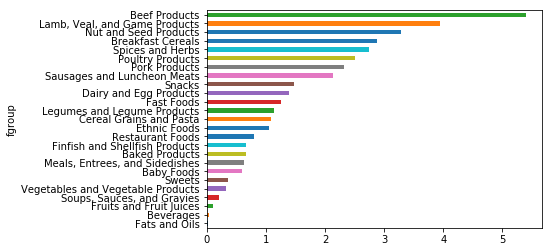

In [235]:
result['Zinc, Zn'].sort_values().plot(kind='barh') # 'Series' object has no attribute 'order'

In [236]:
by_nutrient = ndata.groupby(['nutgroup', 'nutrient'])

In [237]:
get_maximum = lambda x: x.xs(x.value.idxmax())

In [238]:
get_minimum = lambda x: x.xs(x.value.idxmin())

In [239]:
max_foods = by_nutrient.apply(get_maximum)[['value', 'food']]

In [240]:
max_foods

value  \
nutgroup    nutrient                                     
Amino Acids Alanine                              8.009   
            Arginine                             7.436   
            Aspartic acid                       10.203   
            Cystine                              1.307   
            Glutamic acid                       17.452   
            Glycine                             19.049   
            Histidine                            2.999   
            Hydroxyproline                       0.803   
            Isoleucine                           4.300   
            Leucine                              7.200   
            Lysine                               6.690   
            Methionine                           1.859   
            Phenylalanine                        4.600   
            Proline                             12.295   
            Serine                               4.600   
            Threonine                            3.300   
            Tryptophan                           1.600   
            Tyrosine                             3.300   
            Valine                               4.500   
Composition Adjusted Protein                    12.900   
            Carbohydrate, by difference        100.000   
            Fiber, total dietary                79.000   
            Protein                             88.320   
            Sugars, total                       99.800   
            Total lipid (fat)                  100.000   
            Water                              100.000   
Elements    Calcium, Ca                       7364.000   
            Copper, Cu                          15.050   
            Fluoride, F                        584.000   
            Iron, Fe                            87.470   
...                                                ...   
Vitamins    Cryptoxanthin, beta               6186.000   
            Dihydrophylloquinone               103.800   
            Folate, DFE                       2630.000   
            Folate, food                      2340.000   
            Folate, total                     2340.000   
            Folic acid                        1538.000   
            Lutein + zeaxanthin              39550.000   
            Lycopene                         46260.000   
            Menaquinone-4                       33.200   
            Niacin                              97.000   
            Pantothenic acid                    35.000   
            Retinol                          30000.000   
            Riboflavin                          14.300   
            Thiamin                             20.000   
            Tocopherol, beta                     6.490   
            Tocopherol, delta                   30.880   
            Tocopherol, gamma                  100.880   
            Vitamin A, IU                   100000.000   
            Vitamin A, RAE                   30000.000   
            Vitamin B-12                        98.890   
            Vitamin B-12, added                 24.000   
            Vitamin B-6                         12.000   
            Vitamin C, total ascorbic acid    2400.000   
            Vitamin D                        10000.000   
            Vitamin D (D2 + D3)                250.000   
            Vitamin D2 (ergocalciferol)         28.100   
            Vitamin D3 (cholecalciferol)        27.400   
            Vitamin E (alpha-tocopherol)       149.400   
            Vitamin E, added                    46.550   
            Vitamin K (phylloquinone)         1714.500   

                                                                                         food  
nutgroup    nutrient                                                                           
Amino Acids Alanine                                         Gelatins, dry powder, unsweetened  
            Arginine                                             Seeds, sesame flour, low-fat  
          

In [241]:
max_foods.food = max_foods.food.str[:50]

In [242]:
max_foods

value  \
nutgroup    nutrient                                     
Amino Acids Alanine                              8.009   
            Arginine                             7.436   
            Aspartic acid                       10.203   
            Cystine                              1.307   
            Glutamic acid                       17.452   
            Glycine                             19.049   
            Histidine                            2.999   
            Hydroxyproline                       0.803   
            Isoleucine                           4.300   
            Leucine                              7.200   
            Lysine                               6.690   
            Methionine                           1.859   
            Phenylalanine                        4.600   
            Proline                             12.295   
            Serine                               4.600   
            Threonine                            3.300   
            Tryptophan                           1.600   
            Tyrosine                             3.300   
            Valine                               4.500   
Composition Adjusted Protein                    12.900   
            Carbohydrate, by difference        100.000   
            Fiber, total dietary                79.000   
            Protein                             88.320   
            Sugars, total                       99.800   
            Total lipid (fat)                  100.000   
            Water                              100.000   
Elements    Calcium, Ca                       7364.000   
            Copper, Cu                          15.050   
            Fluoride, F                        584.000   
            Iron, Fe                            87.470   
...                                                ...   
Vitamins    Cryptoxanthin, beta               6186.000   
            Dihydrophylloquinone               103.800   
            Folate, DFE                       2630.000   
            Folate, food                      2340.000   
            Folate, total                     2340.000   
            Folic acid                        1538.000   
            Lutein + zeaxanthin              39550.000   
            Lycopene                         46260.000   
            Menaquinone-4                       33.200   
            Niacin                              97.000   
            Pantothenic acid                    35.000   
            Retinol                          30000.000   
            Riboflavin                          14.300   
            Thiamin                             20.000   
            Tocopherol, beta                     6.490   
            Tocopherol, delta                   30.880   
            Tocopherol, gamma                  100.880   
            Vitamin A, IU                   100000.000   
            Vitamin A, RAE                   30000.000   
            Vitamin B-12                        98.890   
            Vitamin B-12, added                 24.000   
            Vitamin B-6                         12.000   
            Vitamin C, total ascorbic acid    2400.000   
            Vitamin D                        10000.000   
            Vitamin D (D2 + D3)                250.000   
            Vitamin D2 (ergocalciferol)         28.100   
            Vitamin D3 (cholecalciferol)        27.400   
            Vitamin E (alpha-tocopherol)       149.400   
            Vitamin E, added                    46.550   
            Vitamin K (phylloquinone)         1714.500   

                                                                                         food  
nutgroup    nutrient                                                                           
Amino Acids Alanine                                         Gelatins, dry powder, unsweetened  
            Arginine                                             Seeds, sesame flour, low-fat  
          

DataFrame.xs（key，axis = 0，level = None，drop_level = True )  
返回Series / DataFrame的横截面（行或列）。默认为行上的横截面（轴= 0）。

In [243]:
df = DataFrame(np.random.randn(3, 3),
               columns=list('abc'),
               index=list('123'))

In [244]:
df

,a,b,c
1,0.303349,-1.107238,-0.976152
2,-2.132725,0.542522,-0.225276
3,2.750476,1.703181,-0.491991


In [245]:
df.xs('1') # 默认axis=0

a    0.303349
b   -1.107238
c   -0.976152
Name: 1, dtype: float64